# $$Section\ A:\ Predict\ who\ will\ recover\ from\ leukemia\ with\ linear\ regression $$

### $ Presented\ by\ Ji\ He $
### $ whitemoonjihe@gmail.com $

## $ Loading\ releated\ packages $

In [1]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import seaborn as sns
import metrics from sklearn
import pandas as pd
from ggplot import *
%matplotlib inline


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1487594514.log


This non-commercial license of GraphLab Create for academic use is assigned to whitemoonjihe@gmail.com and will expire on January 09, 2018.


## $ Define\ some\ help\ functions $

In [2]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 
    features = ['constant'] + features
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [3]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

In [4]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    return (normalized_features, norms)

## $ Loading\ data $

In [5]:
clin = graphlab.SFrame(data='/home/stein/Desktop/clustering/csvdata/mydata_clin.csv')  

Finished parsing file /home/stein/Desktop/clustering/csvdata/mydata_clin.csv

Parsing completed. Parsed 100 lines in 0.009525 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,int,str,int,str,float,float,int,str,int,str,int,float,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/stein/Desktop/clustering/csvdata/mydata_clin.csv

Parsing completed. Parsed 207 lines in 0.008001 secs.

In [6]:
clin # 病人信息

X1,USI,age,age.grp,age.grp.lab,gender,gender.lab,wbc,log.wbc,wbc.grp
PALIYD,PALIYD,10.8227241615,1,Old,0,Female,175.0,2.24303804869,1
PAKJGT,PAKJGT,5.40999315537,0,Young,1,Male,142.0,2.15228834438,1
PAKVKK,PAKVKK,14.3737166324,1,Old,1,Male,220.7,2.34380233316,1
PALGWT,PALGWT,1.57973990418,0,Young,1,Male,129.0,2.1105897103,1
PALSXP,PALSXP,12.6187542779,1,Old,1,Male,26.0,1.41497334797,0
PAMBWU,PAMBWU,14.4804928131,1,Old,1,Male,14.7,1.16731733475,0
PALFBA,PALFBA,10.9158110883,1,Old,1,Male,68.6,1.83632411571,1
PALAVV,PALAVV,13.2950034223,1,Old,1,Male,21.4,1.33041377335,0
PALFNT,PALFNT,12.8076659822,1,Old,1,Male,2.4,0.380211241712,0
PALGAJ,PALGAJ,2.17932922656,0,Young,1,Male,21.0,1.32221929473,0


In [7]:
x = graphlab.SFrame(data='/home/stein/Desktop/clustering/csvdata/mydata_x.csv') 

Finished parsing file /home/stein/Desktop/clustering/csvdata/mydata_x.csv

Parsing completed. Parsed 100 lines in 0.074624 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,fl

Finished parsing file /home/stein/Desktop/clustering/csvdata/mydata_x.csv

Parsing completed. Parsed 207 lines in 0.065958 secs.

In [8]:
x  #病人基因表达数据

X1,HLA_DRB4,HLA_DQB1,IGJ,ZNF711,NPY,SHANK3,AKAP12
PALIYD,8.69514882178,5.80964666133,3.59948036465,2.37325823416,5.54199583237,2.5261417229,2.75379628539
PAKJGT,9.06002214075,5.86735880817,5.34254684403,3.31851485302,3.52979833398,8.80785883568,5.41429618154
PAKVKK,9.39602258336,7.73721042253,11.9087885753,6.38908215238,3.76187363328,6.35436616179,5.29116306823
PALGWT,10.699987059,2.87238347187,3.40517640825,7.0705274083,8.88102224394,3.69393666834,5.60847703098
PALSXP,10.3044623119,8.49415614009,4.53164984661,7.83134257483,4.63713527656,7.82653886702,9.76074914332
PAMBWU,4.42756493936,6.83009096112,9.00067180089,2.96618948574,4.09276608263,5.7381740809,5.24664036615
PALFBA,7.57589741291,2.65905548244,9.89846186339,2.88318710693,4.11959817191,3.27765130493,4.78806787292
PALAVV,4.68646544701,7.55905519704,5.47045252947,8.1024627595,10.3410522386,9.12646157223,2.23132126791
PALFNT,3.87764390948,5.39980035801,3.94849325848,2.59951778467,6.57114984573,5.50169341042,8.21569377305
PALGAJ,4.72094034179,7.01144971757,3.76145900483,5.15487080923,9.70428342933,6.47116087538,3.78594959161


In [9]:
patients = clin.join(x)

In [10]:
patients # all data merged together

X1,USI,age,age.grp,age.grp.lab,gender,gender.lab,wbc,log.wbc,wbc.grp
PALIYD,PALIYD,10.8227241615,1,Old,0,Female,175.0,2.24303804869,1
PAKJGT,PAKJGT,5.40999315537,0,Young,1,Male,142.0,2.15228834438,1
PAKVKK,PAKVKK,14.3737166324,1,Old,1,Male,220.7,2.34380233316,1
PALGWT,PALGWT,1.57973990418,0,Young,1,Male,129.0,2.1105897103,1
PALSXP,PALSXP,12.6187542779,1,Old,1,Male,26.0,1.41497334797,0
PAMBWU,PAMBWU,14.4804928131,1,Old,1,Male,14.7,1.16731733475,0
PALFBA,PALFBA,10.9158110883,1,Old,1,Male,68.6,1.83632411571,1
PALAVV,PALAVV,13.2950034223,1,Old,1,Male,21.4,1.33041377335,0
PALFNT,PALFNT,12.8076659822,1,Old,1,Male,2.4,0.380211241712,0
PALGAJ,PALGAJ,2.17932922656,0,Young,1,Male,21.0,1.32221929473,0


In [11]:
patients.shape

(207, 1018)

In [12]:
patients = patients.dropna()

In [13]:
patients.shape

(184, 1018)

In [14]:
(train_vali_data, test_data) = patients.random_split(0.7, seed = 0)

In [15]:
train_vali_data.shape

(126, 1018)

In [16]:
test_data.shape

(58, 1018)

## $ feature\ selection\ with\ lasso\ regression.$

### Single Coordinate Descent Step

Using the formula above, implement coordinate descent that minimizes the cost function over a single feature i. Note that the intercept (weight 0) is not regularized. The function should accept feature matrix, output, current weights, l1 penalty, and index of feature to optimize over. The function should return new weight for feature i.

In [17]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # compute prediction
    prediction = predict_output(feature_matrix, weights)
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
    ro_i = sum(feature_matrix[:,i]*(output - prediction + weights[i]*feature_matrix[:,i]))

    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2.:
        new_weight_i = ro_i + l1_penalty/2
    elif ro_i > l1_penalty/2.:
        new_weight_i = ro_i - l1_penalty/2
    else:
        new_weight_i = 0.
    
    return new_weight_i

### Cyclical coordinate descent

In [18]:
def is_bigger_than_a(L, a):
    for i in L:
        if i > a:
            return True
    return False

In [19]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    weights = initial_weights
    change = [tolerance*10]*len(weights)
    while is_bigger_than_a(change, tolerance):
        for i in range(len(weights)):
            if change[i] > tolerance:
                old_weights_i = weights[i]
                weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
                change[i] = abs(weights[i] - old_weights_i)
    return weights

### $the\ function\  draws\ ROC\ curve $

In [20]:
def draw_roc(target, predictions, data):
    fpr, tpr, _ = metrics.roc_curve(data[target], predictions)
    auc = np.trapz(tpr, fpr)
    print "auc value is: " + str(auc)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    return ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed'),auc

### $Evaluating\ LASSO\ fit\ with\ some\ features $

In [21]:
l1_penalty_space = np.logspace(0,1,num = 100)-1
print l1_penalty_space

[ 0.          0.02353102  0.04761575  0.07226722  0.09749877  0.12332403
  0.149757    0.17681195  0.20450354  0.23284674  0.26185688  0.29154967
  0.32194115  0.35304777  0.38488637  0.41747416  0.45082878  0.48496826
  0.51991108  0.55567614  0.59228279  0.62975083  0.66810054  0.70735265
  0.7475284   0.78864953  0.83073828  0.87381742  0.91791026  0.96304065
  1.009233    1.05651231  1.10490414  1.15443469  1.20513074  1.25701972
  1.3101297   1.36448941  1.42012826  1.47707636  1.53536449  1.59502421
  1.65608778  1.71858824  1.7825594   1.84803587  1.91505306  1.98364724
  2.05385551  2.12571585  2.19926714  2.27454916  2.35160265  2.43046929
  2.51119173  2.59381366  2.67837977  2.76493581  2.85352859  2.94420606
  3.03701726  3.1320124   3.22924287  3.32876128  3.43062146  3.53487851
  3.64158883  3.75081016  3.86260158  3.97702356  4.09413801  4.21400829
  4.33669923  4.46227722  4.59081018  4.72236766  4.85702082  4.9948425
  5.13590727  5.28029144  5.42807312  5.57933225  5.

In [22]:
features = ['age', 
               'age.grp',
               'gender',
               'wbc',
               'log.wbc',
               'wbc.grp',
               'mrd',
               'TTE'
              ]
my_output = 'outcome'

## $ Optimize\ parameters\ with\ the\ help\ of\ k-folder\ cross\ validation$

In [23]:
def lasso_k_fold_cross_validation(k, l1_penalty, data, output_name, features_list, tolerance):
    initial_weights = [0]*(len(features_list)+1)
    n = len(data)
    ARSS_vali = 0
    AUC_vali = 0
    for i in range(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation_set = data[start:end+1]
        training_set = data[:start].append(data[end+1:])
        
        (feature_matrix_train, output_train) = get_numpy_data(training_set, features_list, output_name)
        normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)
        
        (feature_matrix_vali, output_vali) = get_numpy_data(validation_set, features_list, output_name)
        normalized_feature_matrix_vali, norms_vali = normalize_features(feature_matrix_vali)
        
        weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
        
        
        predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
        fpr_vali, tpr_vali, _ = metrics.roc_curve(output_vali, predictions_vali)
        auc_vali = np.trapz(tpr_vali, fpr_vali)
        AUC_vali += auc_vali
        ARSS_vali += sum((predictions_vali - output_vali)**2)/len(output_vali)
    return ARSS_vali / k, AUC_vali / k

In [24]:
lasso_all_arss_vali = []
lasso_all_auc_vali = []


for l1_penalty in l1_penalty_space:
    arss, auc =lasso_k_fold_cross_validation(9, l1_penalty, 
                                             train_vali_data, my_output, features,  0.5)
    print arss, auc
    
    lasso_all_arss_vali.append(arss)
    lasso_all_auc_vali.append(auc)
    

0.755952030558 0.991666666667
0.752252626102 0.991666666667
0.74675754548 0.991666666667
0.738495195659 0.991666666667
0.730751095434 0.991666666667
0.722715007964 0.991666666667
0.714783943915 0.991666666667
0.707305034682 0.997222222222
0.700086734404 0.997222222222
0.69254699154 0.997222222222
0.685071723017 0.997222222222
0.677480268641 0.997222222222
0.669834211719 0.997222222222
0.662350239563 0.997222222222
0.654916873057 0.997222222222
0.647538957682 0.997222222222
0.640065049162 0.997222222222
0.6319465432 0.997222222222
0.623798081579 0.997222222222
0.60162935472 0.997222222222
0.593836855007 0.997222222222
0.586339483361 0.997222222222
0.57893440881 0.997222222222
0.571099271145 0.997222222222
0.565250289306 0.997222222222
0.557270588389 0.997222222222
0.549085273909 0.997222222222
0.540892964516 0.997222222222
0.532929736145 0.997222222222
0.525047002082 0.997222222222
0.517259411615 0.997222222222
0.509753732341 0.997222222222
0.50271788761 0.997222222222
0.496117730856 0.

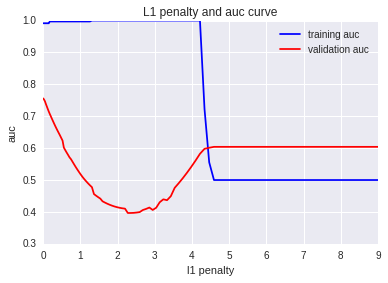

In [25]:
plt.figure()
line1, = plt.plot(l1_penalty_space, lasso_all_auc_vali, color = 'blue', label = 'training auc')
line2, = plt.plot(l1_penalty_space, lasso_all_arss_vali, color = 'red', label = 'validation auc')
plt.title('L1 penalty and auc curve')
plt.xlabel('l1 penalty')
plt.ylabel('auc')
plt.legend(handles=[line1,line2], loc=1)
plt.grid(True)
plt.show()

In [26]:
initial_weights = [0]*(len(features)+1)
tolerance = 0.5
l1_penalty = 2.2

In [27]:
(feature_matrix_test, output_test) = get_numpy_data(test_data, features, my_output)
normalized_feature_matrix_test, norms_test = normalize_features(feature_matrix_test)

In [28]:
(feature_matrix_train, output_train) = get_numpy_data(train_vali_data, features, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [29]:
weights_train = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
print weights_train

[6.832163615603994, 0.0, 0.0, 0.0, 0.2841322207241429, 0.0, 0.0, 0.21041392889107124, -4.324253001185892]


In [30]:
def get_nonzero_feature(weights, features):
    nonzero_features = []
    if weights[0] != 0:
        nonzero_features.append('intercept')
    for i in range(1, len(weights)):
        if weights[i] != 0:
            nonzero_features.append(features[i-1])
    return nonzero_features

In [31]:
print get_nonzero_feature(weights_train, features)

['intercept', 'wbc', 'mrd', 'TTE']


In [32]:
predictions_test = predict_output(normalized_feature_matrix_test, weights_train)
arss_test = sum((output_test - predictions_test)**2)/len(output_test)
print arss_test
print predictions_test
print output_test

0.0722712869563
[  8.78191518e-01   7.30257019e-01   1.65224617e-01   1.07113705e+00
   3.56068820e-01   8.19527040e-01   8.29690629e-01   7.56144885e-01
   9.90121647e-01   9.64106320e-02   5.84962996e-01   6.33625892e-01
   1.70921076e-01   2.34526999e-01   8.42766715e-01  -2.91477570e-04
  -2.79747165e-02   5.60906971e-01   1.28760984e-01   7.22348168e-01
   3.63497190e-01   2.76967895e-01   2.87817216e-01   6.85281429e-01
   5.47854586e-01   7.74394050e-01   6.20851750e-01   7.82231077e-01
   1.57582118e-01   6.61864768e-01   5.30455891e-02   5.35021368e-01
   6.26353533e-02   5.17125351e-02   6.66911469e-01   8.54966777e-01
   6.86756680e-01   2.82346210e-01   4.91934588e-02  -3.41684253e-02
   6.62740380e-01   4.48069872e-01   5.18858307e-01   2.96000967e-01
   2.61886814e-01   8.07307481e-01  -2.80212899e-02   6.27677648e-02
   1.44841207e-01   8.39130649e-01   7.79805610e-01   1.46164580e-01
   8.18585863e-01   2.77432765e-01  -1.52823524e-03   1.15493838e-01
   5.18131244e-01 

auc value is: 1.0


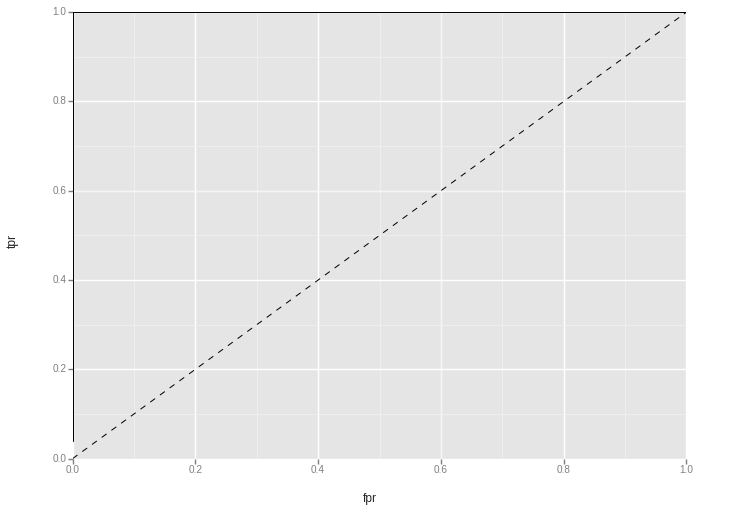

(<ggplot: (8732234213177)>, 1.0)

In [33]:
draw_roc('outcome', predictions_test, test_data)

In [34]:
(training_data, vali_data) = patients.random_split(0.75, seed = 0)

In [35]:
(feature_matrix_train, output_train) = get_numpy_data(training_data, features, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [36]:
(feature_matrix_vali, output_vali) = get_numpy_data(vali_data, features, my_output)
normalized_feature_matrix_vali, norms_vali = normalize_features(feature_matrix_vali)

In [37]:
all_weights = []
all_arss_train = []
all_arss_vali = []
for l1_penalty in l1_penalty_space:
    weights = []
    weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
    predictions_train = predict_output(normalized_feature_matrix_train, weights)
    predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
    arss_train = sum((output_train - predictions_train)**2)/len(output_train)
    arss_vali = sum((output_vali - predictions_vali)**2)/len(output_vali)
    all_arss_train.append(arss_train)
    all_arss_vali.append(arss_vali)
    d = copy.deepcopy(weights)
    all_weights.append(d)
    print get_nonzero_feature(weights, features)

['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age.grp', 'wbc', 'mrd', 'TTE']
['intercept', 'age.grp', 'wbc', 'mrd', 'TTE']
['intercept', 'age.grp', 'wbc', 'mrd', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'age.grp', 'wbc', 'TTE']
['intercept', 'a

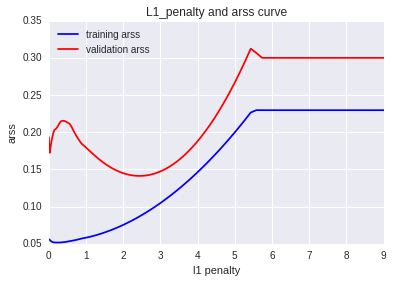

In [38]:
plt.figure()
line1, = plt.plot(l1_penalty_space, all_arss_train, color = 'blue', label = 'training arss')
line2, = plt.plot(l1_penalty_space, all_arss_vali, color = 'red', label = 'validation arss')
plt.title('L1_penalty and arss curve')
plt.xlabel('l1 penalty')
plt.ylabel('arss')
plt.legend(handles=[line1, line2], loc=2)
plt.grid(True)
plt.show()

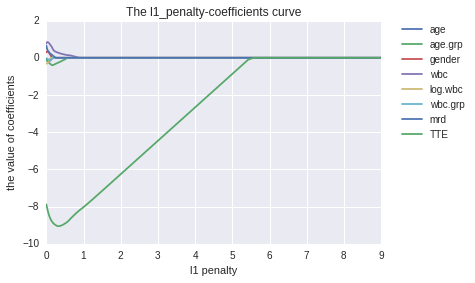

In [39]:
plt.figure()
lines = []
for j in range(len(all_weights[0])):
    if j != 0:
        examp1 = []
        for i in range(len(all_weights)):
            examp1.append(all_weights[i][j])
        line, = plt.plot(l1_penalty_space,examp1)
        lines.append(line)
    else:
        pass
plt.title('The l1_penalty-coefficients curve')
plt.xlabel("l1 penalty")
plt.ylabel("the value of coefficients")
plt.legend(lines, features, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [40]:
all_weights = []
all_auc_train = []
all_auc_vali = []
for l1_penalty in l1_penalty_space:
    weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
    predictions_train = predict_output(normalized_feature_matrix_train, weights)
    predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
    fpr_train, tpr_train, _ = metrics.roc_curve(output_train, predictions_train)
    auc_train = np.trapz(tpr_train,fpr_train)
    fpr_vali, tpr_vali, _ = metrics.roc_curve(output_vali, predictions_vali)
    
    auc_vali = np.trapz(tpr_vali, fpr_vali)
    print '=============================================================================================='
    print auc_vali,auc_train
    print '=============================================================================================='
    #print weights
    print get_nonzero_feature(weights, features)
    deepcopy_auc_train = copy.deepcopy(auc_train)
    deepcopy_auc_vali = copy.deepcopy(auc_vali)
    deepcopy_weight = copy.deepcopy(weights)
    all_auc_train.append(deepcopy_auc_train)
    all_auc_vali.append(deepcopy_auc_vali)
    all_weights.append(deepcopy_weight)

0.949891067538 0.965111111111
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.978213507625 0.985777777778
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.989106753813 0.991777777778
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.99128540305 0.994222222222
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.993464052288 0.995555555556
['intercept', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.995642701525 0.996444444444
['intercept', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.997821350763 0.997111111111
['intercept', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.997821350763 0.997555555556
['intercept', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.997821350763 0.998222222222
['intercept', 'age.grp', 'gender', 'wbc', 'log.wbc', 'mrd', 'TTE']
1.0 0.998222

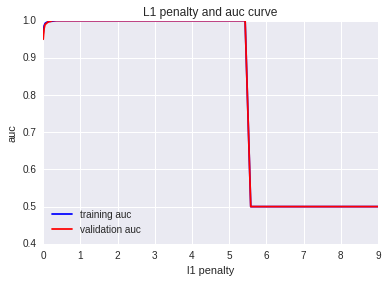

In [41]:
plt.figure()
line1, = plt.plot(l1_penalty_space, all_auc_train, color = 'blue', label = 'training auc')
line2, = plt.plot(l1_penalty_space, all_auc_vali, color = 'red', label = 'validation auc')
plt.title('L1 penalty and auc curve')
plt.xlabel('l1 penalty')
plt.ylabel('auc')
plt.legend(handles=[line1, line2], loc=3)
plt.grid(True)
plt.show()

## $ Try\ ridge\ regression $

In [42]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        return 2*np.dot(feature, errors)
    else:  #Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
        return 2*np.dot(feature, errors) + 2*l2_penalty*weight

In [43]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations):
    weights = [0]*len(initial_weights) # make sure it's a numpy array
    j = 0
    while j < max_iterations:
    #while not reached maximum number of iterations:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)
            # subtract the step size times the derivative from the current weight
            weights[i] -= step_size*derivative
        j += 1
    return weights


In [44]:
def ridge_k_fold_cross_validation(k, l2_penalty, data, output_name, features_list, max_iterations, step_size):
    initial_weights = [0]*(len(features_list)+1)
    n = len(data)
    ARSS_vali = 0
    AUC_vali = 0
    for i in range(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation_set = data[start:end+1]
        training_set = data[:start].append(data[end+1:])
        
        (feature_matrix_train, output_train) = get_numpy_data(training_set, features_list, output_name)
        normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)
        
        (feature_matrix_vali, output_vali) = get_numpy_data(validation_set, features_list, output_name)
        normalized_feature_matrix_vali, norms_vali = normalize_features(feature_matrix_vali)
        
        weights = ridge_regression_gradient_descent(normalized_feature_matrix_train, output_train,
                               initial_weights, step_size, l2_penalty, max_iterations)
        predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
        fpr_vali, tpr_vali, _ = metrics.roc_curve(output_vali, predictions_vali)
        auc_vali = np.trapz(tpr_vali, fpr_vali)
        AUC_vali += auc_vali
        ARSS_vali += sum((predictions_vali - output_vali)**2)/len(output_vali)
    return ARSS_vali / k, AUC_vali / k

In [45]:
l2_penalty_space = np.logspace(0,1,num = 100)-1
print l2_penalty_space
step_size = 1e-2
max_iterations = 1000

[ 0.          0.02353102  0.04761575  0.07226722  0.09749877  0.12332403
  0.149757    0.17681195  0.20450354  0.23284674  0.26185688  0.29154967
  0.32194115  0.35304777  0.38488637  0.41747416  0.45082878  0.48496826
  0.51991108  0.55567614  0.59228279  0.62975083  0.66810054  0.70735265
  0.7475284   0.78864953  0.83073828  0.87381742  0.91791026  0.96304065
  1.009233    1.05651231  1.10490414  1.15443469  1.20513074  1.25701972
  1.3101297   1.36448941  1.42012826  1.47707636  1.53536449  1.59502421
  1.65608778  1.71858824  1.7825594   1.84803587  1.91505306  1.98364724
  2.05385551  2.12571585  2.19926714  2.27454916  2.35160265  2.43046929
  2.51119173  2.59381366  2.67837977  2.76493581  2.85352859  2.94420606
  3.03701726  3.1320124   3.22924287  3.32876128  3.43062146  3.53487851
  3.64158883  3.75081016  3.86260158  3.97702356  4.09413801  4.21400829
  4.33669923  4.46227722  4.59081018  4.72236766  4.85702082  4.9948425
  5.13590727  5.28029144  5.42807312  5.57933225  5.

In [46]:
ridge_all_arss_cross_vali = []
ridge_all_auc_cross_vali = []


for l2_penalty in l2_penalty_space:
    ridge_arss_cross_vali, ridge_auc_cross_vali =ridge_k_fold_cross_validation(9, l2_penalty, 
                                             train_vali_data, my_output, features, max_iterations, step_size)
    print ridge_arss_cross_vali, ridge_auc_cross_vali 
    ridge_all_arss_cross_vali.append(ridge_arss_cross_vali)
    ridge_all_auc_cross_vali.append(ridge_auc_cross_vali )
    

0.843214777259 0.975925925926
0.75565281402 0.973456790123
0.690766952326 0.973456790123
0.641897682304 0.970679012346
0.604576731199 0.967901234568
0.575745258633 0.967901234568
0.553267630132 0.967901234568
0.535624180856 0.962654320988
0.521713809812 0.962654320988
0.510724962 0.962654320988
0.502049861196 0.962654320988
0.495226535795 0.962654320988
0.489898991843 0.962654320988
0.485789422124 0.955092592593
0.482678520559 0.955092592593
0.480391335738 0.955092592593
0.478786964028 0.949537037037
0.477750940897 0.949537037037
0.477189553644 0.947067901235
0.477025539907 0.947067901235
0.477194797969 0.944598765432
0.477643844494 0.941820987654
0.478327830587 0.941820987654
0.479208979342 0.941820987654
0.480255344729 0.941820987654
0.481439817796 0.939043209877
0.482739324858 0.936574074074
0.484134175972 0.931018518519
0.485607531968 0.928703703704
0.487144965684 0.928703703704
0.488734098596 0.923148148148
0.49036429818 0.92037037037
0.492026424517 0.92037037037
0.493712617076 0.

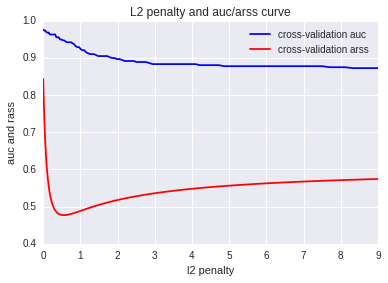

In [47]:
plt.figure()
line1, = plt.plot(l2_penalty_space, ridge_all_auc_cross_vali, color = 'blue', label = 'cross-validation auc')
line2, = plt.plot(l2_penalty_space, ridge_all_arss_cross_vali, color = 'red', label = 'cross-validation arss')
plt.title('L2 penalty and auc/arss curve')
plt.xlabel('l2 penalty')
plt.ylabel('auc and rass')
plt.legend(handles=[line1,line2], loc=1)
plt.grid(True)
plt.show()

In [48]:
step_size = 1e-2
max_iterations = 1000
initial_weights = [0]*(len(features)+1)
l2_penalty = 0.5

In [49]:
(feature_matrix_train, output_train) = get_numpy_data(train_vali_data, features, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [51]:
weights_train = ridge_regression_gradient_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, step_size, l2_penalty, max_iterations)
print weights_train

[4.8047438952950801, -0.01261576634827568, -0.21663983814133686, 0.27058214703086986, 0.68333656136208543, 0.24467276683161068, 0.2094222551573956, 0.71028738956558812, -2.7406993857166904]


In [52]:
print get_nonzero_feature(weights_train, features)

['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']


In [53]:
ridge_predictions_test = predict_output(normalized_feature_matrix_test, weights_train)
ridge_arss_test = sum((output_test - ridge_predictions_test)**2)/len(output_test)
print "the arss of test data is: "+str(ridge_arss_test)

the arss of test data is: 0.108907080601


auc value is: 0.975757575758


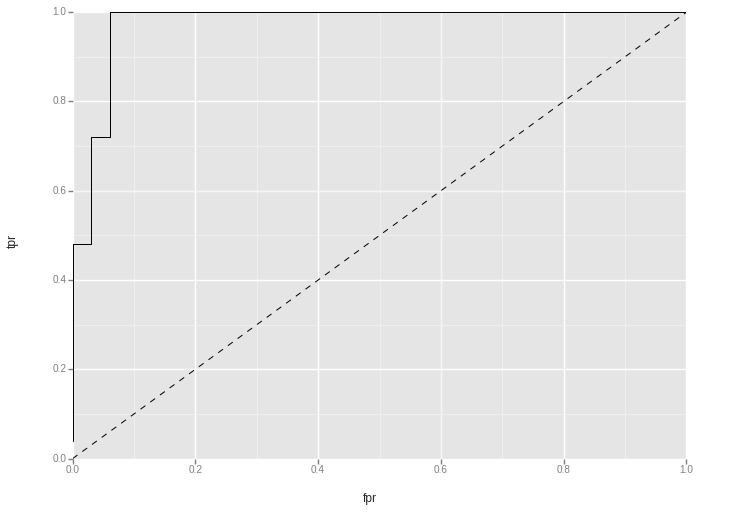

(<ggplot: (8732206782385)>, 0.97575757575757582)

In [54]:
draw_roc(my_output, ridge_predictions_test, test_data)

In [55]:
(feature_matrix_train, output_train) = get_numpy_data(training_data, features, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [56]:
(feature_matrix_vali, output_vali) = get_numpy_data(vali_data, features, my_output)
normalized_feature_matrix_vali, norms_vali = normalize_features(feature_matrix_vali)

In [57]:
all_weights = []
all_arss_train = []
all_arss_vali = []
for l2_penalty in l2_penalty_space:
    weights = ridge_regression_gradient_descent(normalized_feature_matrix_train, output_train,
                               initial_weights, step_size, l2_penalty, max_iterations=1000)

    predictions_train = predict_output(normalized_feature_matrix_train, weights)
    predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
    arss_train = sum((output_train - predictions_train)**2)/len(output_train)
    arss_vali = sum((output_vali - predictions_vali)**2)/len(output_vali)
    all_arss_train.append(arss_train)
    all_arss_vali.append(arss_vali)
    d = copy.deepcopy(weights)
    all_weights.append(d)
    print get_nonzero_feature(weights, features)

['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.

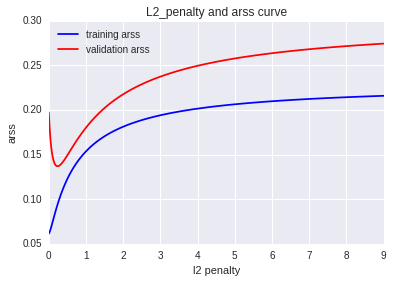

In [58]:
plt.figure()
line1, = plt.plot(l2_penalty_space, all_arss_train, color = 'blue', label = 'training arss')
line2, = plt.plot(l2_penalty_space, all_arss_vali, color = 'red', label = 'validation arss')
plt.title('L2_penalty and arss curve')
plt.xlabel('l2 penalty')
plt.ylabel('arss')
plt.legend(handles=[line1, line2], loc=2)
plt.grid(True)
plt.show()

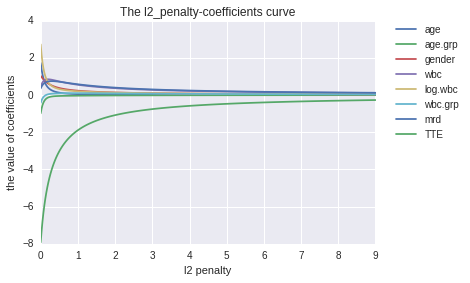

In [59]:
plt.figure()
lines = []
for j in range(len(all_weights[0])):
    if j != 0:
        examp1 = []
        for i in range(len(all_weights)):
            examp1.append(all_weights[i][j])
        line, = plt.plot(l2_penalty_space,examp1)
        lines.append(line)
    else:
        pass
plt.title('The l2_penalty-coefficients curve')
plt.xlabel("l2 penalty")
plt.ylabel("the value of coefficients")
plt.legend(lines, features, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

In [60]:
all_weights = []
all_auc_train = []
all_auc_vali = []
for l2_penalty in l2_penalty_space:
    weights = ridge_regression_gradient_descent(normalized_feature_matrix_train, output_train,
                               initial_weights, step_size, l2_penalty, max_iterations=1000)
    predictions_train = predict_output(normalized_feature_matrix_train, weights)
    predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
    fpr_train, tpr_train, _ = metrics.roc_curve(output_train, predictions_train)
    auc_train = np.trapz(tpr_train,fpr_train)
    fpr_vali, tpr_vali, _ = metrics.roc_curve(output_vali, predictions_vali)
    
    auc_vali = np.trapz(tpr_vali, fpr_vali)
    print '=============================================================================================='
    print auc_vali,auc_train
    print '=============================================================================================='
    #print weights
    print get_nonzero_feature(weights, features)
    #print weights
    deepcopy_auc_train = copy.deepcopy(auc_train)
    deepcopy_auc_vali = copy.deepcopy(auc_vali)
    deepcopy_weight = copy.deepcopy(weights)
    all_auc_train.append(deepcopy_auc_train)
    all_auc_vali.append(deepcopy_auc_vali)
    all_weights.append(deepcopy_weight)

0.989106753813 0.994222222222
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.986928104575 0.993777777778
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.986928104575 0.993555555556
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.986928104575 0.993777777778
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.986928104575 0.992444444444
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.986928104575 0.992666666667
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.984749455338 0.991777777778
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.9825708061 0.991111111111
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.wbc', 'wbc.grp', 'mrd', 'TTE']
0.9825708061 0.990666666667
['intercept', 'age', 'age.grp', 'gender', 'wbc', 'log.

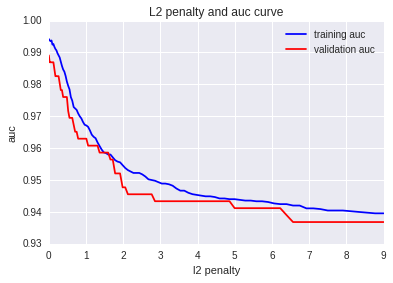

In [61]:
plt.figure()
line1, = plt.plot(l2_penalty_space, all_auc_train, color = 'blue', label = 'training auc')
line2, = plt.plot(l2_penalty_space, all_auc_vali, color = 'red', label = 'validation auc')
plt.title('L2 penalty and auc curve')
plt.xlabel('l2 penalty')
plt.ylabel('auc')
plt.legend(handles=[line1, line2], loc=1)
plt.grid(True)
plt.show()

## $ Conclusions $

### $ 1. Use\ lasso\ regression\ is\ slightly\ better\ than\ ridge\ regression\ according\ to\ auc\ evalution. $

### $ 2. Event\ and\ TTE\ are\ the\ most\ effective\ predictor\ for\ predict\ the\ recover\ from\ leukemia. $

### $ 3. The\ AUC\ value\ can\ reach\ 1\ easily\ with\ feature\ TTE\ or\ Event $ 

## $ But\ we\ want\ more $

### $ 1. we\ want\ to\ do\ the\ whole\ stuff\ without\ TTE\ and\ EVENT.\\
      2. we\ want\ to\ know\ what\ gene\ or\ gene\ combinations\ could\ cause\ leukemia$

# $$ Section\ B:\ feature\ engineering\ on\ gene\ data\ $$

## $ Fail\ of\ Lasso $

In [62]:
x.head()

X1,HLA_DRB4,HLA_DQB1,IGJ,ZNF711,NPY,SHANK3,AKAP12
PALIYD,8.69514882178,5.80964666133,3.59948036465,2.37325823416,5.54199583237,2.5261417229,2.75379628539
PAKJGT,9.06002214075,5.86735880817,5.34254684403,3.31851485302,3.52979833398,8.80785883568,5.41429618154
PAKVKK,9.39602258336,7.73721042253,11.9087885753,6.38908215238,3.76187363328,6.35436616179,5.29116306823
PALGWT,10.699987059,2.87238347187,3.40517640825,7.0705274083,8.88102224394,3.69393666834,5.60847703098
PALSXP,10.3044623119,8.49415614009,4.53164984661,7.83134257483,4.63713527656,7.82653886702,9.76074914332
PAMBWU,4.42756493936,6.83009096112,9.00067180089,2.96618948574,4.09276608263,5.7381740809,5.24664036615
PALFBA,7.57589741291,2.65905548244,9.89846186339,2.88318710693,4.11959817191,3.27765130493,4.78806787292
PALAVV,4.68646544701,7.55905519704,5.47045252947,8.1024627595,10.3410522386,9.12646157223,2.23132126791
PALFNT,3.87764390948,5.39980035801,3.94849325848,2.59951778467,6.57114984573,5.50169341042,8.21569377305
PALGAJ,4.72094034179,7.01144971757,3.76145900483,5.15487080923,9.70428342933,6.47116087538,3.78594959161


In [63]:
gene_names = x.column_names()

In [64]:
print len(gene_names)

1001


In [65]:
gene_names.remove('X1')
gene_names

['HLA_DRB4',
 'HLA_DQB1',
 'IGJ',
 'ZNF711',
 'NPY',
 'SHANK3',
 'AKAP12',
 'SMAD1',
 'SH3BP5',
 'ALOX5',
 'S100A16',
 'TUBB6',
 'BMP2',
 'SIPA1L2',
 'SCML1',
 'DAPK1',
 'HLA_DQA1',
 'CTGF',
 'IGF2BP3',
 'PCDH9',
 'SEMA6A',
 'KLF9',
 'CYGB',
 'KLF4',
 'ANXA5',
 'MTCL1',
 'LYZ',
 'CCND2',
 'ARPP21',
 'FAM101B',
 'RGS1',
 'PDE4B',
 'UBASH3B',
 'EGR1',
 'RGS2',
 'ITGA6',
 'CMTM8',
 'CTA_250D10.23',
 'SOCS2',
 'PRDX2',
 'SLC2A5',
 'IGFBP7',
 'MS4A1',
 'GPM6B',
 'FAM150B',
 'CYTL1',
 'CBX1',
 'KIAA0226L',
 'BTG3',
 'MYH10',
 'TP53INP1',
 'LRIG1',
 'GAB1',
 'IRX1',
 'IQCJ_SCHIP1',
 'MME',
 'SNX9',
 'ACSL1',
 'CYTIP',
 'KLF3',
 'FOSL2',
 'S100A8',
 'UBE2E3',
 'ABCA1',
 'ECM1',
 'LGALS1',
 'NR4A2',
 'EPAS1',
 'SCN3A',
 'FLT3',
 'MAFF',
 'MARCKS',
 'DSTN',
 'MIR155',
 'CLECL1',
 'TCL1A',
 'ARL4C',
 'LOC728175',
 'LOC728613',
 'GPR125',
 'CAPN2',
 'NR4A3',
 'CLEC2B',
 'AL832909',
 'MLLT4',
 'IFI44',
 'ID3',
 'ELK3',
 'PAICS',
 'CD109',
 'IFI44L',
 'NFIL3',
 'BHLHE40',
 'CXXC5',
 'SOCS2_AS1',
 'C

In [66]:
l1_penalty_space_gene = np.logspace(0,1,num = 20)-1
print l1_penalty_space_gene

[ 0.          0.12883789  0.27427499  0.43844989  0.62377674  0.83298071
  1.06913808  1.33572147  1.6366509   1.97635144  2.35981829  2.79269019
  3.2813324   3.83293024  4.45559478  5.15848211  5.95192796  6.8475997
  7.8586679   9.        ]


In [67]:
lasso_all_arss_cross_vali_gene = []
lasso_all_auc_cross_vali_gene = []


for l1_penalty in l1_penalty_space_gene:
    arss, auc = lasso_k_fold_cross_validation(3, l1_penalty, 
                                        train_vali_data, my_output, gene_names,  0.5)
    print arss, auc
    lasso_all_arss_cross_vali_gene.append(arss)
    lasso_all_auc_cross_vali_gene.append(auc)

0.173351750668 0.833084045584
0.201760212993 0.777226146869
0.211575599421 0.735497339962
0.219368254248 0.733797023083
0.23300188626 0.716395575324
0.242283470854 0.63064749404
0.243630244758 0.512019230769
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5
0.24417962191 0.5


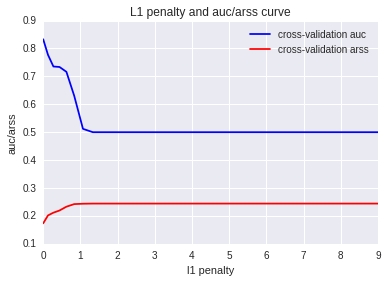

In [69]:
plt.figure()
line1, = plt.plot(l1_penalty_space_gene, lasso_all_auc_cross_vali_gene, color = 'blue', label = 'cross-validation auc')
line2, = plt.plot(l1_penalty_space_gene, lasso_all_arss_cross_vali_gene, color = 'red', label = 'cross-validation arss')
plt.title('L1 penalty and auc/arss curve')
plt.xlabel('l1 penalty')
plt.ylabel('auc/arss')
plt.legend(handles=[line1,line2], loc=1)
plt.grid(True)
plt.show()

In [70]:
initial_weights = [0]*(len(gene_names)+1)

In [71]:
(feature_matrix_train, output_train) = get_numpy_data(train_vali_data, gene_names, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [72]:
(feature_matrix_test, output_test) = get_numpy_data(test_data, gene_names, my_output)
normalized_feature_matrix_test, norms_test = normalize_features(feature_matrix_test)

In [113]:
lasso_weights_train_gene = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, 0.6, 0.5)
lasso_weights_train_gene

[3.7720924603225128,
 0.0,
 0.0,
 0.38308428072360051,
 0.0,
 0.0,
 0.0,
 -0.059722894541338778,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.31528895726078038,
 0.0,
 0.0,
 -0.2231906979116321,
 0.084200499792429329,
 0.16165502974860202,
 0.0,
 0.086991284896684284,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.29241272826644943,
 0.0,
 0.0,
 0.0,
 -0.016806494396070681,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.067047347860492157,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.62393020830463031,
 0.0,
 0.23110867666447904,
 0.0,
 0.0,
 0.0,
 0.056298792126750541,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.19620405119850587,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.059019416366507427,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.29034433371325535,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

In [114]:
lasso_predictions_test_gene = predict_output(normalized_feature_matrix_test, lasso_weights_train_gene)
lasso_arss_test_gene = sum((output_test - lasso_predictions_test_gene)**2)/len(output_test)
print lasso_arss_test_gene

0.233864183844


In [115]:
print normalized_feature_matrix_test.shape

(58, 1001)


auc value is: 0.637575757576


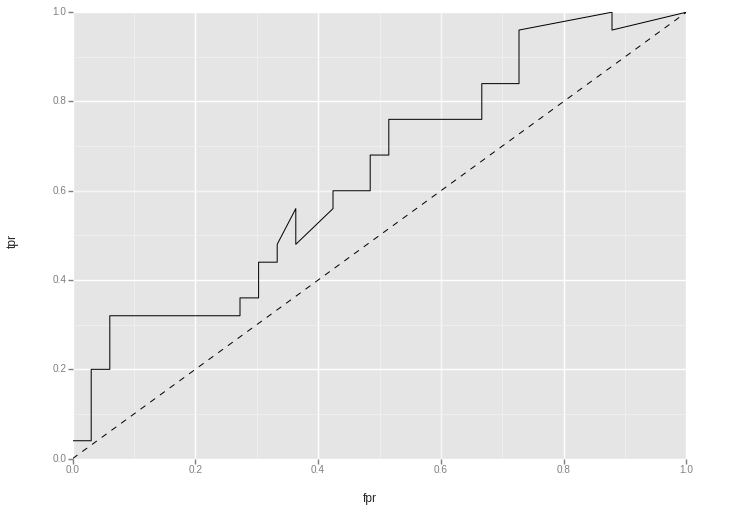

(<ggplot: (8732205896917)>, 0.63757575757575757)

In [116]:
draw_roc(my_output, lasso_predictions_test_gene, test_data)

### $ Fail\ of\ ridge\ regression. $

In [117]:
l2_penalty_space_gene = np.logspace(0,1,num = 20)-1
print l2_penalty_space_gene

[ 0.          0.12883789  0.27427499  0.43844989  0.62377674  0.83298071
  1.06913808  1.33572147  1.6366509   1.97635144  2.35981829  2.79269019
  3.2813324   3.83293024  4.45559478  5.15848211  5.95192796  6.8475997
  7.8586679   9.        ]


In [ ]:
ridge_all_arss_cross_vali_gene = []
ridge_all_auc_cross_vali_gene = []


for l2_penalty in l2_penalty_space:
    ridge_arss_cross_vali_gene, ridge_auc_cross_vali_gene =ridge_k_fold_cross_validation(3, l2_penalty, 
                                             train_vali_data, my_output, gene_names, 1000, 1e-2)
    print ridge_arss_cross_vali_gene, ridge_auc_cross_vali_gene 
    ridge_all_arss_cross_vali_gene.append(ridge_arss_cross_vali_gene)
    ridge_all_auc_cross_vali_gene.append(ridge_auc_cross_vali_gene)
    

/home/stein/anaconda3/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/stein/anaconda3/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/home/stein/anaconda3/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in double_scalars
/home/stein/anaconda3/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in double_scalars


nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572
nan 0.485250232572


In [292]:
all_weights = []
all_auc_train = []
all_auc_vali = []
for l1_penalty in l1_penalty_space:
    weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
    predictions_train = predict_output(normalized_feature_matrix_train, weights)
    predictions_vali = predict_output(normalized_feature_matrix_vali,weights)
    fpr_train, tpr_train, _ = metrics.roc_curve(output_train, predictions_train)
    auc_train = np.trapz(tpr_train,fpr_train)
    fpr_vali, tpr_vali, _ = metrics.roc_curve(output_vali, predictions_vali)
    
    auc_vali = np.trapz(tpr_vali, fpr_vali)
    print '=============================================================================================='
    print auc_vali,auc_train
    print '=============================================================================================='
    #print weights
    print get_nonzero_feature(weights, gene_names)
    deepcopy_auc_train = copy.deepcopy(auc_train)
    deepcopy_auc_vali = copy.deepcopy(auc_vali)
    deepcopy_weight = copy.deepcopy(weights)
    all_auc_train.append(deepcopy_auc_train)
    all_auc_vali.append(deepcopy_auc_vali)
    all_weights.append(deepcopy_weight)

0.584415584416 0.990373935579
['intercept', 'HLA_DRB4', 'HLA_DQB1', 'IGJ', 'ZNF711', 'NPY', 'SHANK3', 'AKAP12', 'SMAD1', 'SH3BP5', 'ALOX5', 'S100A16', 'TUBB6', 'BMP2', 'SIPA1L2', 'SCML1', 'DAPK1', 'HLA_DQA1', 'CTGF', 'IGF2BP3', 'PCDH9', 'SEMA6A', 'KLF9', 'CYGB', 'KLF4', 'ANXA5', 'MTCL1', 'LYZ', 'CCND2', 'ARPP21', 'FAM101B', 'RGS1', 'PDE4B', 'UBASH3B', 'EGR1', 'RGS2', 'ITGA6', 'CMTM8', 'CTA_250D10.23', 'SOCS2', 'PRDX2', 'SLC2A5', 'IGFBP7', 'MS4A1', 'GPM6B', 'FAM150B', 'CYTL1', 'CBX1', 'KIAA0226L', 'BTG3', 'MYH10', 'TP53INP1', 'LRIG1', 'GAB1', 'IRX1', 'IQCJ_SCHIP1', 'MME', 'SNX9', 'ACSL1', 'CYTIP', 'KLF3', 'FOSL2', 'S100A8', 'UBE2E3', 'ABCA1', 'ECM1', 'LGALS1', 'NR4A2', 'EPAS1', 'SCN3A', 'FLT3', 'MAFF', 'MARCKS', 'DSTN', 'MIR155', 'CLECL1', 'TCL1A', 'ARL4C', 'LOC728175', 'LOC728613', 'GPR125', 'CAPN2', 'NR4A3', 'CLEC2B', 'AL832909', 'MLLT4', 'IFI44', 'ID3', 'ELK3', 'PAICS', 'CD109', 'IFI44L', 'NFIL3', 'BHLHE40', 'CXXC5', 'SOCS2_AS1', 'CSGALNACT1', 'TLE1', 'CD99', 'SERPINB9', 'ID2', 'P2RX

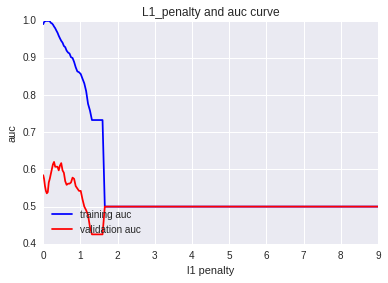

In [293]:
plt.figure()
line1, = plt.plot(l1_penalty_space, all_auc_train, color = 'blue', label = 'training auc')
line2, = plt.plot(l1_penalty_space, all_auc_vali, color = 'red', label = 'validation auc')
plt.title('L1_penalty and auc curve')
plt.xlabel('l1 penalty')
plt.ylabel('auc')
plt.legend(handles=[line1, line2], loc=3)
plt.grid(True)
plt.show()

In [61]:
print all_auc_vali

[0.8928571428571429, 0.93506493506493515, 0.96428571428571419, 0.9642857142857143, 0.96103896103896103, 0.96753246753246758, 0.98376623376623384, 0.98701298701298701, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5]


In [296]:
initial_weights = [0]*(len(gene_names)+1)
l1_penalty=0.5
tolerance=0.5

In [297]:
weights = lasso_cyclical_coordinate_descent(normalized_feature_matrix_train, output_train,
                                            initial_weights, l1_penalty, tolerance)
print weights

[3.5813399773348888, 0.0, 0.0, 0.36694223849076013, -0.18370933916386151, -0.13445393286993307, 0.0, -0.054455090745535006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.16552479570586326, 0.0, 0.0, 0.0, 0.33548359158377861, 0.095345278148482426, -0.24970235779484889, 0.21344197843370372, 0.0, 0.0, -0.14180595429788251, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0054987198515050739, -0.3407611994712989, 0.0, 0.15893075268749896, 0.0, -0.1280227425751162, 0.0, 0.12821737046318893, 0.0, 0.01323255399981671, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039497157791223703, 0.0, 0.0, -0.051660373252327751, 0.12097480244882713, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01281877992756375, 0.0, -0.0059253708277205996, -0.033060585749029037, 0.089788554945772758, 0.0, -0.058799202926805683, 0.0, 0.0092689442287398061, 0.0, 0.0, 0.0, -0.0078572521592720213, 0.0, 0.082787762722149438, 0.0, 0.0, 0.0, 0.0, -0.010831163487097617, 0.0, -0.36909684383535424, 0.056769527085775318, 0.0, 0.0, 0.0, 0.095707267655440298, 0.0, 0.0, 0.0,

In [299]:
print get_nonzero_feature(weights, gene_names)

['intercept', 'IGJ', 'ZNF711', 'NPY', 'AKAP12', 'SIPA1L2', 'CTGF', 'IGF2BP3', 'PCDH9', 'SEMA6A', 'KLF4', 'FAM101B', 'RGS1', 'UBASH3B', 'RGS2', 'CMTM8', 'SOCS2', 'TP53INP1', 'IRX1', 'IQCJ_SCHIP1', 'FOSL2', 'UBE2E3', 'ABCA1', 'ECM1', 'NR4A2', 'SCN3A', 'DSTN', 'CLECL1', 'GPR125', 'NR4A3', 'CLEC2B', 'ID3', 'IFI44L', 'SOCS2_AS1', 'NT5E', 'ELL2', 'ANTXR2', 'SMAD7', 'SIK1', 'JMY', 'PECAM1', 'DLL1', 'TOX2', 'EMP1', 'GFOD1', 'IRAK3', 'VPREB1', 'TRAF3IP3', 'PON2', 'HDGFRP3', 'GOLGA8A', 'HS3ST3B1', 'BAALC', 'SKI', 'NR1D2', 'TTC28', 'FAM65B', 'TIMP1', 'TSPAN7', 'CSNK1A1', 'C6orf62', 'FAM129A', 'SUCLG2', 'BRAF', 'SDC2', 'IGF2BP2', 'PSPH', 'ITGAM', 'MYO1G', 'RNMT', 'KLF7']


In [300]:
predictions_train = predict_output(normalized_feature_matrix_train, weights)
arss_train = sum((output_train - predictions_train)**2)/len(output_train)
print arss_train
print predictions_train
print output_train

0.185529464929
[ 0.29717316  0.17434172  0.34117707  0.52980772  0.29900668  0.21143367
  0.32822843  0.18032176  0.30947571  0.30869199  0.42105997  0.34688378
  0.31550559  0.44382352  0.33386085  0.37070539  0.35892909  0.33114086
  0.38704688  0.29777848  0.36710438  0.2674678   0.29428873  0.43792372
  0.31869851  0.19891018  0.48932601  0.29909795  0.34808749  0.42487788
  0.55985052  0.35063187  0.32032635  0.51805477  0.28559242  0.18759584
  0.32459989  0.33104265  0.38382039  0.29723228  0.27968234  0.20576886
  0.47626133  0.29642606  0.39517332  0.41092612  0.32112168  0.21467926
  0.25769173  0.49275297  0.17177158  0.40430568  0.50678285  0.27144804
  0.36443414  0.33740748  0.40584818  0.35358467  0.3329582   0.34597188
  0.49679075  0.39658581  0.35831429  0.35451477  0.40178369  0.22256006
  0.30216756  0.30020335  0.28462536  0.32695265  0.47461228  0.22784457
  0.17744308  0.24173158  0.42129629  0.32250142  0.32507057  0.35292207
  0.24652224  0.54132648  0.31998978

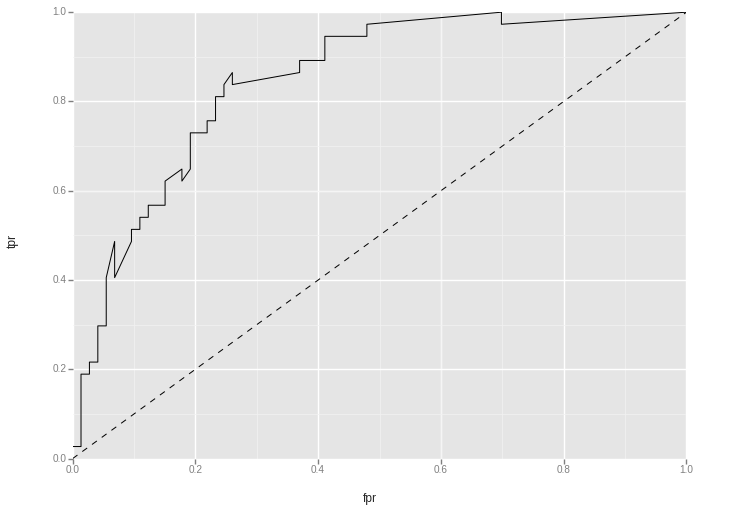

<ggplot: (8731284810949)>

In [303]:
draw_roc(my_output, predictions_train, p_train)

In [304]:
predictions_test = predict_output(normalized_feature_matrix_test, weights)
arss_test = sum((output_test - predictions_test)**2)/len(output_test)
print arss_test
print predictions_test
print output_test
print weights

0.26147584715
[ 0.59252259  0.84739024  0.67265602  0.56378906  0.42423397  0.58170134
  0.63706278  0.61810177  0.70810091  0.28070614  0.61374411  0.55456868
  0.47696153  0.52598717  0.66653664  0.44195059  0.38220049  0.57613546
  0.52876176  0.91136597  0.83229754  0.87208039  0.51115723  0.67482406
  0.3392899   0.82947685  0.41869762  0.68092748  0.4878624   0.4945234
  0.37523139  0.85292321  0.473054    0.56132482  0.54310265  0.67849125
  0.37157627  0.24519083]
[0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1
 1]
[3.5813399773348888, 0.0, 0.0, 0.36694223849076013, -0.18370933916386151, -0.13445393286993307, 0.0, -0.054455090745535006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.16552479570586326, 0.0, 0.0, 0.0, 0.33548359158377861, 0.095345278148482426, -0.24970235779484889, 0.21344197843370372, 0.0, 0.0, -0.14180595429788251, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0054987198515050739, -0.3407611994712989, 0.0, 0.15893075268749896, 0.0, -0.1280227425751162, 0.0, 0.128217

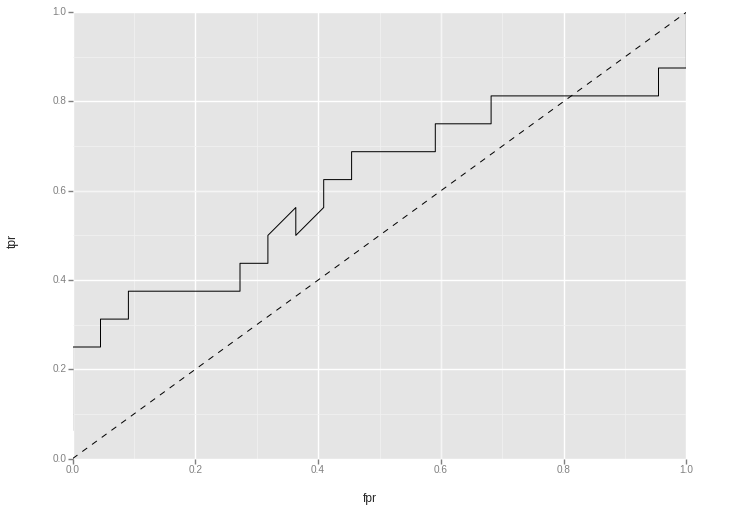

<ggplot: (8731299750181)>

In [305]:
draw_roc(my_output, predictions_test, p_test)

In [307]:
auc = np.trapz(tpr,fpr)
print auc

0.613636363636


## Investigate more with deep neural network

In [195]:
print len(gene_names)

1000


In [196]:
gene_clean_train = p_train[gene_names]
gene_clean_train['outcome'] = p_train['outcome']

In [197]:
gene_clean_train.shape

(110, 1001)

In [198]:
my_output = 'outcome'

In [199]:
(feature_matrix_train, output_train) = get_numpy_data(gene_clean_train, gene_names, my_output)
normalized_feature_matrix_train, norms_train = normalize_features(feature_matrix_train)

In [200]:
feature_matrix_train.shape

(110, 1001)

In [201]:
print feature_matrix_train.shape

(110, 1001)


In [202]:
from keras.models import Sequential

In [203]:
model = Sequential()

In [204]:
from keras.layers import Dense, Activation

In [212]:
model.add(Dense(output_dim = 5, input_dim = 1001))
model.add(Activation('relu'))
model.add(Dense(output_dim = 1))
model.add(Activation('softmax'))

In [213]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [214]:
model.fit(feature_matrix_train, output_train, nb_epoch=5, batch_size=1)

Epoch 1/5
110/110 [==============================] - 0s - loss: 10.5799 - acc: 0.3364         

## A new algorithm(detecting leukemia based wholly on gene data)

### 1. Measures the correlations between feature "output" and genes 

In [68]:
patients_data_clean = pd.read_csv('/home/stein/Desktop/clustering/csvdata/patients_clean.csv')

In [69]:
patients_data_clean

,X1,USI,age,age.grp,age.grp.lab,gender,gender.lab,wbc,log.wbc,wbc.grp,...,PDE8A,MST4,TMEM107,SLC35A1,HSPB1,NR3C1,TSC22D3,ARHGAP24,SLAIN1,LPXN
0,PALIYD,PALIYD,10.82270,1,Old,0,Female,175.0,2.243040,1,...,6.36496,7.12443,4.25945,5.50438,8.65811,7.12227,8.95041,2.93882,4.92166,7.57143
1,PAKJGT,PAKJGT,5.40999,0,Young,1,Male,142.0,2.152290,1,...,5.23165,5.00758,4.26900,4.33788,7.94753,7.52816,9.46312,5.77044,2.97919,5.69660
2,PAKVKK,PAKVKK,14.37370,1,Old,1,Male,220.7,2.343800,1,...,6.22506,5.95098,3.99329,5.15666,9.66871,7.39021,9.71068,8.33177,6.41563,6.97599
3,PALSXP,PALSXP,12.61880,1,Old,1,Male,26.0,1.414970,0,...,6.00636,5.34861,6.09322,4.97844,7.79239,8.04213,8.76113,7.05297,3.20023,5.67869
4,PALFBA,PALFBA,10.91580,1,Old,1,Male,68.6,1.836320,1,...,3.41909,3.67631,3.68898,3.93561,8.13543,5.87371,6.56930,3.91902,3.40857,4.77456
5,PALAVV,PALAVV,13.29500,1,Old,1,Male,21.4,1.330410,0,...,5.30952,6.97229,2.72769,5.33878,8.09731,9.30126,11.15120,3.02341,3.65052,7.02443
6,PALFNT,PALFNT,12.80770,1,Old,1,Male,2.4,0.380211,0,...,5.72198,5.43462,3.42929,5.88180,9.32362,9.09969,9.30446,3.33570,6.62834,5.09332
7,PALGAJ,PALGAJ,2.17933,0,Young,1,Male,21.0,1.322220,0,...,3.45731,4.74642,3.47347,4.01720,8.14368,4.49411,9.15314,3.51497,2.66966,3.90688
8,PALIBN,PALIBN,14.29980,1,Old,1,Male,29.9,1.475670,0,...,5.35550,6.75901,5.39984,6.17743,8.88625,8.65849,6.34521,8.40519,4.87645,6.38788
9,PAMBDA,PAMBDA,14.01230,1,Old,0,Female,217.2,2.336860,1,...,4.71933,4.26055,2.67568,5.27244,9.61213,7.38385,10.18740,3.68743,3.09178,5.17583


In [70]:
gene_names

['HLA_DRB4',
 'HLA_DQB1',
 'IGJ',
 'ZNF711',
 'NPY',
 'SHANK3',
 'AKAP12',
 'SMAD1',
 'SH3BP5',
 'ALOX5',
 'S100A16',
 'TUBB6',
 'BMP2',
 'SIPA1L2',
 'SCML1',
 'DAPK1',
 'HLA_DQA1',
 'CTGF',
 'IGF2BP3',
 'PCDH9',
 'SEMA6A',
 'KLF9',
 'CYGB',
 'KLF4',
 'ANXA5',
 'MTCL1',
 'LYZ',
 'CCND2',
 'ARPP21',
 'FAM101B',
 'RGS1',
 'PDE4B',
 'UBASH3B',
 'EGR1',
 'RGS2',
 'ITGA6',
 'CMTM8',
 'CTA_250D10.23',
 'SOCS2',
 'PRDX2',
 'SLC2A5',
 'IGFBP7',
 'MS4A1',
 'GPM6B',
 'FAM150B',
 'CYTL1',
 'CBX1',
 'KIAA0226L',
 'BTG3',
 'MYH10',
 'TP53INP1',
 'LRIG1',
 'GAB1',
 'IRX1',
 'IQCJ_SCHIP1',
 'MME',
 'SNX9',
 'ACSL1',
 'CYTIP',
 'KLF3',
 'FOSL2',
 'S100A8',
 'UBE2E3',
 'ABCA1',
 'ECM1',
 'LGALS1',
 'NR4A2',
 'EPAS1',
 'SCN3A',
 'FLT3',
 'MAFF',
 'MARCKS',
 'DSTN',
 'MIR155',
 'CLECL1',
 'TCL1A',
 'ARL4C',
 'LOC728175',
 'LOC728613',
 'GPR125',
 'CAPN2',
 'NR4A3',
 'CLEC2B',
 'AL832909',
 'MLLT4',
 'IFI44',
 'ID3',
 'ELK3',
 'PAICS',
 'CD109',
 'IFI44L',
 'NFIL3',
 'BHLHE40',
 'CXXC5',
 'SOCS2_AS1',
 'C

In [71]:
p_train_succ = p_train[p_train['outcome'] == 0]

In [72]:
p_train_succ

X1,USI,age,age.grp,age.grp.lab,gender,gender.lab,wbc,log.wbc,wbc.grp
PAKJGT,PAKJGT,5.40999315537,0,Young,1,Male,142.0,2.15228834438,1
PALSXP,PALSXP,12.6187542779,1,Old,1,Male,26.0,1.41497334797,0
PALAVV,PALAVV,13.2950034223,1,Old,1,Male,21.4,1.33041377335,0
PALWVU,PALWVU,14.288843258,1,Old,1,Male,180.0,2.2552725051,1
PAKPVX,PAKPVX,14.4503764545,1,Old,1,Male,113.5,2.05499586153,1
PALCAZ,PALCAZ,12.9281314168,1,Old,1,Male,4.4,0.643452676486,0
PALJKB,PALJKB,9.82067077344,0,Young,1,Male,72.2,1.85853719757,1
PAKYEN,PAKYEN,6.86926762491,0,Young,1,Male,1.7,0.230448921378,0
PAKRGU,PAKRGU,4.1916495551,0,Young,0,Female,196.1,2.29247759367,1
PAIXGP,PAIXGP,2.28610540726,0,Young,0,Female,115.0,2.06069784035,1


In [73]:
p_train_fail = p_train[p_train['outcome'] == 1]

In [74]:
p_train_fail

X1,USI,age,age.grp,age.grp.lab,gender,gender.lab,wbc,log.wbc,wbc.grp
PALIBN,PALIBN,14.2997946612,1,Old,1,Male,29.9,1.47567118832,0
PAKSWW,PAKSWW,15.1019849418,1,Old,1,Male,202.4,2.30621050817,1
PALULV,PALULV,15.9945242984,1,Old,1,Male,27.4,1.43775056282,0
PAKPFV,PAKPFV,17.7850787132,1,Old,1,Male,9.1,0.959041392321,0
PALFKF,PALFKF,17.826146475,1,Old,1,Male,515.0,2.71180722904,1
PAMAYA,PAMAYA,3.72621492129,0,Young,1,Male,117.2,2.06892761168,1
PALFZF,PALFZF,1.08966461328,0,Young,0,Female,135.0,2.1303337685,1
PAKLRH,PAKLRH,2.16837782341,0,Young,1,Male,237.0,2.37474834601,1
PAMDRM,PAMDRM,7.871321013,0,Young,1,Male,351.3,2.54567814979,1
PALFGE,PALFGE,3.90417522245,0,Young,1,Male,138.4,2.14113609012,1


In [75]:
print len(p_train_succ),len(p_train_fail)

73 37


In [76]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [77]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                resp[j, k] = weights[k]*multivariate_normal.pdf(data[j],means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments
        #print resp

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        #print counts
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += resp[j, k]*data[j]
            # YOUR CODE HERE
            means[k] = weighted_sum/counts[k]
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += np.outer(resp[j,k]*(data[j]-means[k]),(data[j]-means[k]))
            # YOUR CODE HERE
            covariances[k] = weighted_sum/counts[k]
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

# Explore the gene correlation

In [67]:
patients_data_clean = pd.read_csv('/home/stein/Desktop/clustering/csvdata/patients_clean.csv')

In [81]:
patients_data_clean = patients_data_clean[gene_names]

In [75]:
interested_genes = ['outcome','HLA_DRB4', 'HLA_DQB1', 'IGJ', 'ZNF711', 'TUBB6', 'BMP2', 'CTGF', 'IGF2BP3']

In [89]:
patients_data_clean.outcome.corr(patients_data_clean.CTGF)

0.17388950738366415

In [78]:
corr = patients_data_clean[interested_genes].corr()

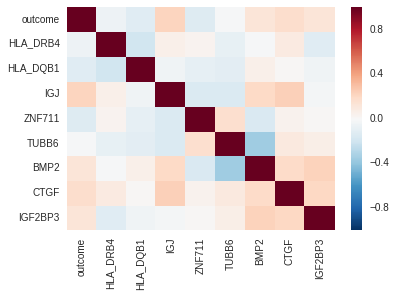

In [79]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print i, (start, end)

In [ ]:
train_valid_shuffled[0:10] # rows 0 to 9

In [ ]:
validation4 = train_valid_shuffled[(n*3)/k:(n*(3+1))/k-1]
print int(round(validation4['price'].mean(), 0))

n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print first_two.append(last_two)

first_half4 = train_valid_shuffled[:(n*3)/k]
last_half4 = train_valid_shuffled[(n*(3+1))/k:]
train4 = first_half4.append(last_half4)


print int(round(train4['price'].mean(), 0))

In [310]:

def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    n = len(data)
    RSS = 0
    for i in range(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation_set = data[start:end+1]
        training_set = data[:start].append(data[end+1:])
        model = graphlab.linear_regression.create(training_set, target = output_name, features = features_list,
                                                  l2_penalty=l2_penalty, validation_set = None, verbose = False)
        prediction = model.predict(validation_set)
        RSS += sum((prediction - validation_set[output_name])**2)
    return RSS / k

In [ ]:

data = polynomial_sframe(train_valid_shuffled['sqft_living'], 15)

features_list = data.column_names()

data['price'] = train_valid_shuffled['price']

k = 10
import numpy as np
p = []
for l2_penalty in np.logspace(1, 7, num = 13):
    h = k_fold_cross_validation(k, l2_penalty, data, 'price', features_list)
    print h, l2_penalty
    p.append(h)
print p